<a href="https://colab.research.google.com/github/linuschui/recyAIcle/blob/main/recyAIcle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U albumentations

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import glob
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#######################################################
#               Define Transforms                     #
#######################################################

train_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=256, width=256),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.CenterCrop(height=256, width=256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [ ]:
####################################################
#       Create Train, Valid and Test sets          #
####################################################
train_data_path = '/content/drive/MyDrive/CatalystAI/recyclables/train'
test_data_path = '/content/drive/MyDrive/CatalystAI/recyclables/test'

train_image_paths = [] # to store image paths in list
classes = [] # to store class values

#1.
# get all the paths from train_data_path and append image paths and class to to respective lists
# eg. train path-> 'images/train/26.Pont_du_Gard/4321ee6695c23c7b.jpg'
# eg. class -> 26.Pont_du_Gard
for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1])
    train_image_paths.append(glob.glob(data_path + '/*'))

train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])

#2.
# split train valid from train paths (80,20)
train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):]

#3.
# create the test_image_paths
test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))

print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))

train_image_path example:  /content/drive/MyDrive/CatalystAI/recyclables/train/paper/DSC_8214-0.jpg
class example:  paper
Train size: 156
Valid size: 39
Test size: 20


In [ ]:
#######################################################
#        Create dictionary for class indexes          #
#######################################################

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}
print(idx_to_class)

{0: 'paper', 1: 'plastic'}


In [ ]:
#######################################################
#               Define Dataset Class                  #
#######################################################

class RecycleDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]

        return image, label

#######################################################
#                  Create Dataset                     #
#######################################################

train_dataset = RecycleDataset(train_image_paths,train_transforms)
valid_dataset = RecycleDataset(valid_image_paths,test_transforms) #test transforms are applied
test_dataset = RecycleDataset(test_image_paths,test_transforms)


In [ ]:
print('The shape of tensor for 50th image in train dataset: ',train_dataset[49][0].shape)
print('The label for 10th image in train dataset: ',train_dataset[9][1])

The shape of tensor for 50th image in train dataset:  torch.Size([3, 256, 256])
The label for 10th image in train dataset:  0


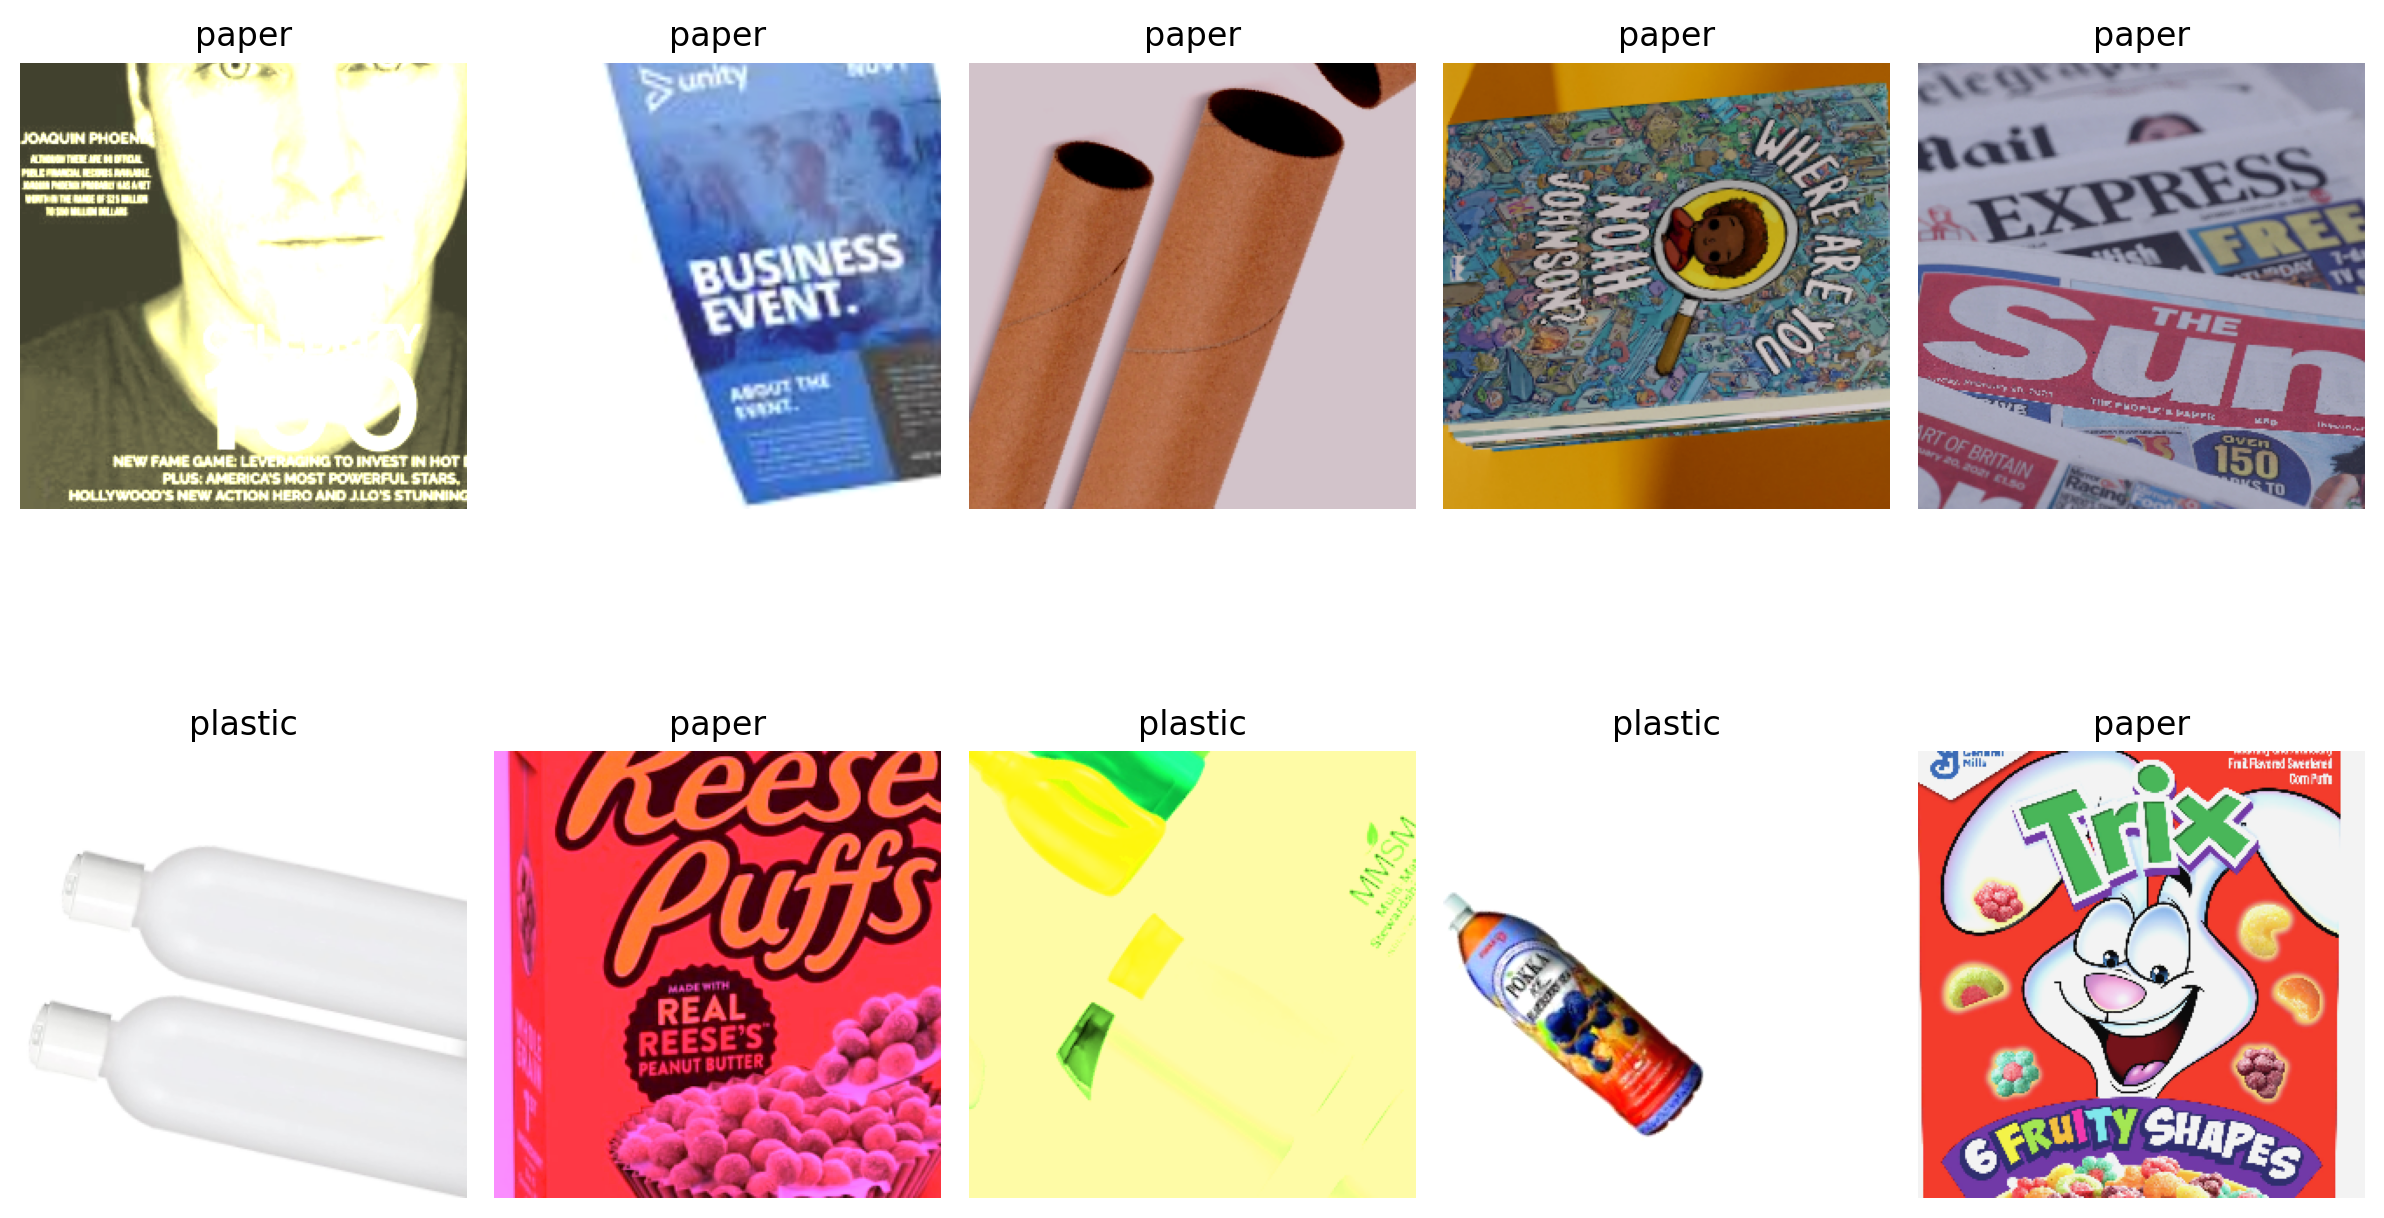

In [31]:
#######################################################
#                  Visualize Dataset                  #
#         Images are plotted after augmentation       #
#######################################################

def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img = False):

    dataset = copy.deepcopy(dataset)
    #we remove the normalize and tensor conversion from our augmentation pipeline
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols


    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(train_image_paths))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()

visualize_augmentations(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)

In [ ]:
#######################################################
#                  Define Dataloaders                 #
#######################################################

train_loader = DataLoader(
    train_dataset, batch_size=10, shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=5, shuffle=True
)


test_loader = DataLoader(
    test_dataset, batch_size=5, shuffle=False
)

In [ ]:
next(iter(train_loader))[0].shape

torch.Size([10, 3, 256, 256])

In [ ]:
next(iter(train_loader))[1].shape

torch.Size([10])

In [ ]:
#######################################################
#               Define Hyperparameters                #
#######################################################
torch.manual_seed(0)
learning_rate = 0.001
batch_size = 20
num_epochs = 20
num_classes = 2

In [ ]:
#######################################################
#                      Build Model                    #
#######################################################
class recyAIcle(nn.Module):
    def __init__(self, num_classes=2):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 64 * 64, 128)  # Adjusted based on the input size
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
#######################################################
#                      Train Model                    #
#######################################################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = recyAIcle(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epoch_losses = []

for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
      inputs, labels = inputs.to(device), labels.to(device)
      # reset optimizer
      optimizer.zero_grad()
      # forward pass
      outputs = model(inputs)
      # compute loss
      loss = criterion(outputs, labels)
      # backward pass
      loss.backward()
      # take optimizer step to update weights
      optimizer.step()
      # compute stats
      running_loss += loss.item()
  epoch_losses.append(running_loss)
  print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}')

checkpoint = {
        'epoch': num_epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
}
torch.save(checkpoint, '/content/drive/MyDrive/CatalystAI/model.pt')

In [ ]:
#######################################################
#                    Evaluate Model                   #
#######################################################
correct = 0
total = 0

test_model = recyAIcle()
checkpoint = torch.load('/content/drive/MyDrive/CatalystAI/model.pt')
test_model.load_state_dict(checkpoint['model_state_dict'])

with torch.no_grad():
     for inputs, labels in tqdm(test_loader, desc='Testing'):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = test_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        # print('\n--------------')
        # print(predicted)
        # print('--------------')
        # print(labels)
        # print('--------------')
        correct += (predicted == labels).sum().item()
        # print(predicted, labels)

accuracy = correct / total
print(f'\nTest Accuracy: {accuracy * 100:.2f}%')

Testing: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


Test Accuracy: 90.00%
